In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn
from scipy.interpolate import interp1d

In [335]:
def basic_labeling(title=None):
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel('voltage (mV)', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xlim([0, nrn._tmax])
    
def getSTFFT(x, fs, wbin=1000, mbin=10):
    freq = np.fft.fftfreq(wbin, 1/fs)[:(wbin//2)]
    ids = np.arange(wbin//2, len(x)-wbin//2, mbin)
    xfft = np.zeros([len(freq), len(ids)-1])
    for i in range(len(ids)-1):
        x_tmp = x[ids[i]-wbin//2:ids[i]+wbin//2]
        y = np.fft.fft(x_tmp) / len(x_tmp)
        xfft[:, i] = 2*abs(y[:(wbin//2)])
    ids_mid = (ids[2:] + ids[1:-1])//2
    t = ids_mid/fs
    return t, freq, xfft

def get_spk_hist(vcells, t, w=100, m=10):
    n = len(t)
    ids = np.arange(0, n-w+1, m)
    nid = len(ids)
    hist = np.zeros(nid)    
    boolx = vcells == 30
    for n in range(nid):
        hist[n] = np.sum(boolx[ids[n]:ids[n]+w])
    x = np.array(t)
    x = x[ids]
    return hist, x

def getFFT(x, idt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# constant current

In [282]:
nrn.set_times(tmax=300, dt=0.01)
seed = 102107
nrn.set_seed(seed)

## Complete graph

In [283]:
# create fully connected network
def create_network(n_exc, n_inh):
    # cell types
    ctypes = []
    for i in range(n_exc):
        ctypes.append(0)
    for i in range(n_inh):
        ctypes.append(1)
    # network
    n_cells = n_exc + n_inh
    num_gtypes = [[0, 1], [2, 3]]
    adj_mat = []
    for i in range(n_cells):
        ctype_pre = ctypes[i]
        adj_mat.append([])
        for j in range(n_cells):
            if i == j:
                adj_mat[i].append(-1)
            else:
                ctype_post = ctypes[j]
                adj_mat[i].append(num_gtypes[ctype_pre][ctype_post])
    return ctypes, adj_mat

In [284]:
n_exc = 80
n_inh = 20
n_cells = n_exc + n_inh
# create cell types
cell_types, adj_mat = create_network(n_exc, n_inh)

In [285]:
amp_exc = 1
amp_inh = 1e-2
i_exc = nrn.current_clamp(50, 250, amp_exc)
i_inh = nrn.current_clamp(50, 250, amp_inh)
i_all = np.array([i_exc, i_inh]).T
target_id = [[], []]
for n in range(n_cells):
    if n < n_exc:
        target_id[0].append(n)
    else:
        target_id[1].append(n)

In [300]:
params_pn = {'tau':20, 'r':100, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':100, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
syn_pn2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pn2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':-80}
syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [301]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, adj_mat)

In [302]:
ntk = nrn.CellNetwork(**setting, Iext=i_all, target_id=target_id, std=0.2)
ntk.run()

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [02:26<00:00, 204.95it/s]


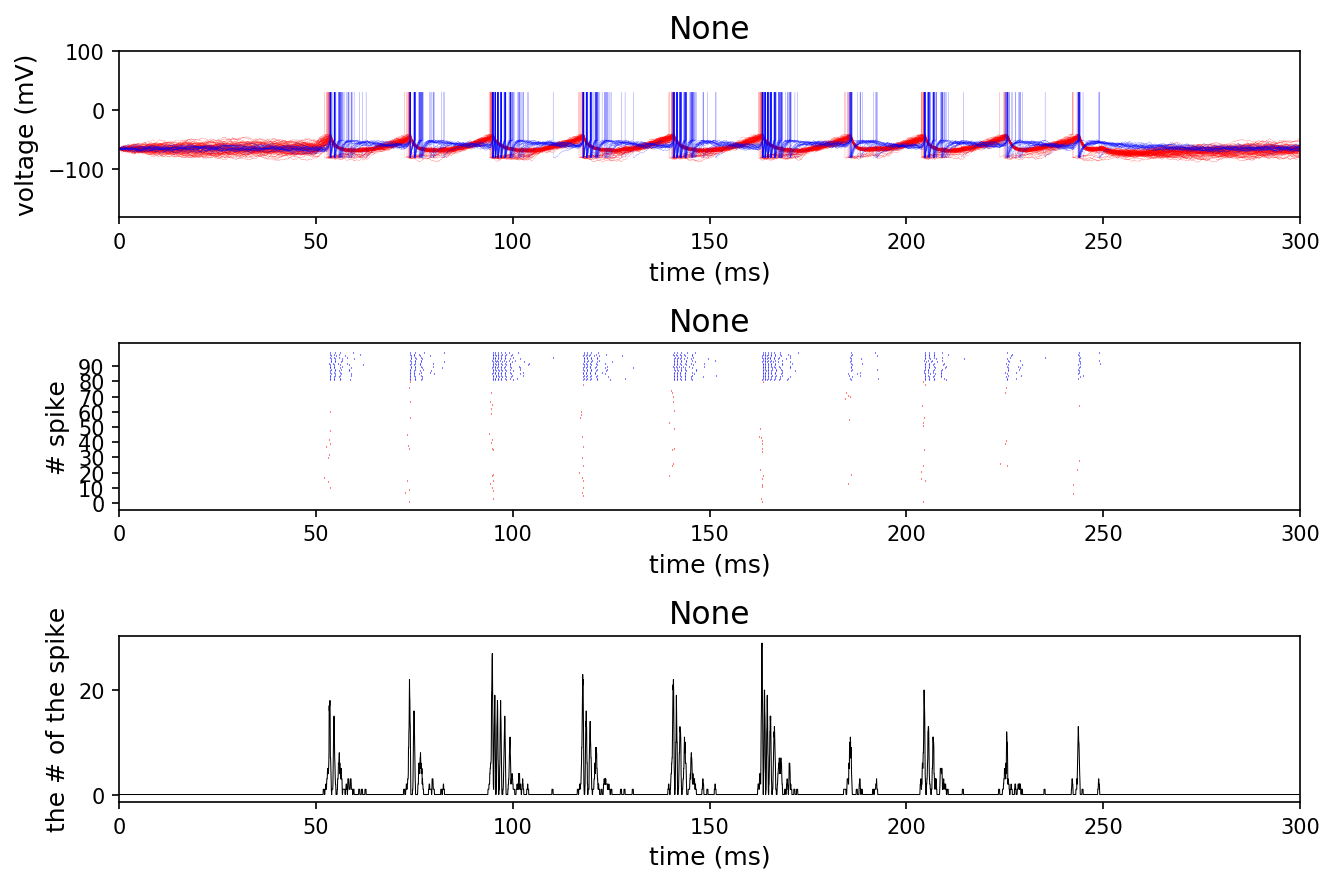

In [303]:
cs = ['r', 'b']

plt.figure(dpi=150, figsize=(9, 6))
plt.subplot(3,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
basic_labeling()
plt.ylim([-180, 100])

plt.subplot(3,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling()
plt.ylabel('# spike')
# plt.yticks(list(range(1, n_exc+n_inh+1)))
plt.yticks(np.arange(0, n_cells, 10))

plt.subplot(3,1,3)
hist, x = get_spk_hist(ntk.vcells, nrn._times, w=30, m=5)
plt.plot(x, hist, 'k', lw=0.5)
basic_labeling()
plt.ylabel('the # of the spike')
# plt.ylim([0, 1])

plt.tight_layout()
plt.show()

In [304]:
vsum = np.average(ntk.vcells, axis=1)
idt = (nrn._times>50) & (nrn._times<300)

fx = np.fft.fft(vsum[idt]) / sum(idt)
f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
fx = abs(fx[:int(sum(idt)//2)])
f = f[:int(sum(idt)//2)]

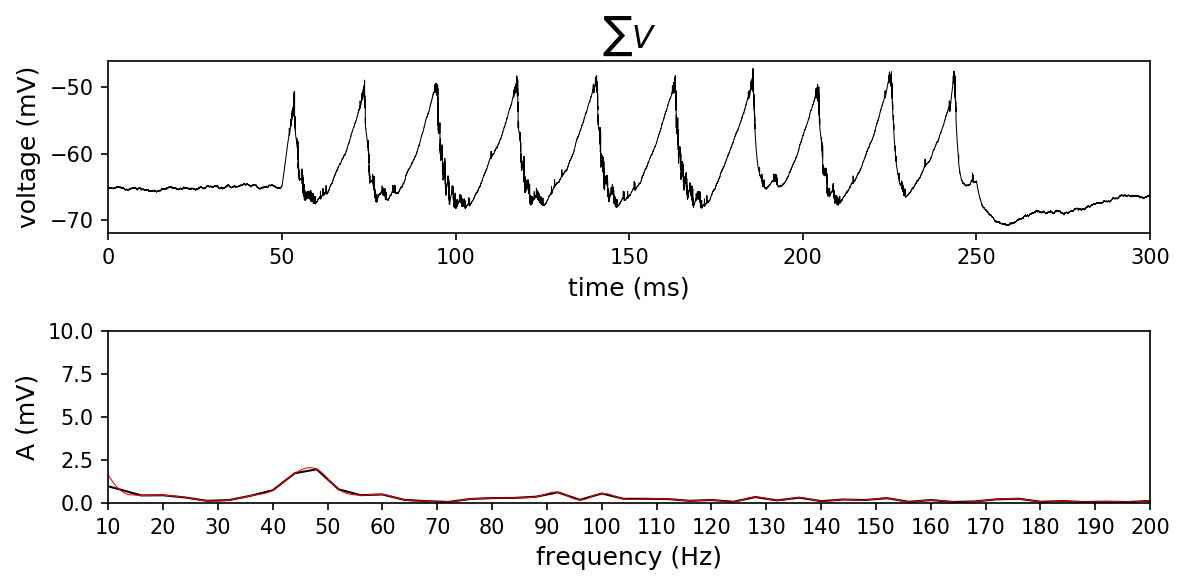

In [305]:
plt.figure(dpi=150, figsize=(8, 4))

finterp = interp1d(f, fx, kind='quadratic')
fnew = np.linspace(10, 200, 1000)

plt.subplot(211)
plt.plot(nrn._times, vsum, 'k', lw=0.5)
basic_labeling(r'$\sum{ V}$')
plt.subplot(212)
plt.plot(f, fx, 'k', lw=1)
plt.plot(fnew, finterp(fnew), 'r', lw=0.5)
plt.xlim([10, 200])
plt.ylim([0, 10])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel('A (mV)', fontsize=12)
plt.xticks(np.arange(10, 210, 10))

plt.tight_layout()
plt.show()

# Poisson input

## complete graph

In [373]:
nrn.set_times(tmax=1000, dt=0.01)
nrn.set_seed(100112)

In [374]:
n_exc = 16
n_inh = 4
n_cells = n_exc + n_inh
cell_types, cnt_map = create_network(n_exc, n_inh)

In [397]:
# avg: 2
g_excs = []
e_excs = []
target_ids = []

targets = []
for i in range(n_cells):
    targets.append(i)
    targets.append(i)

for i in range(n_cells):
    g_excs.append(nrn.gPoisson(0.1, 0.1, 5, delay=0, t0=100, t1=900))
    e_excs.append(0)
    # pick two cells
    target_ids.append([np.random.choice(targets)])
    targets.remove(target_ids[-1][0])
    while True:
        n = np.random.choice(targets)
        if n != target_ids[-1][0]:
            target_ids[-1].append(n)
            targets.remove(target_ids[-1][1])
            break
g_excs = np.array(g_excs).T

In [398]:
# syn_pn2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pn2pv = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pv2pn = {'gbar_syn':0.02, 'tau_r':0.1, 'tau_d':5, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.004, 'tau_r':0.1, 'tau_d':5, 'es':-80}

syn_pn2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pn2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':-80}
syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

# syn_pn2pn = {'gbar_syn':0.03, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pn2pv = {'gbar_syn':0.0125, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pv2pn = {'gbar_syn':0.03, 'tau_r':0.1, 'tau_d':5, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.0125, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [399]:
gbar_excs = []
for i in range(n_cells):
    gbar_excs.append([])
    for j in target_ids[i]:
        if cell_types[j] == 0: # exc
            gbar_excs[-1].append(syn_pn2pn['gbar_syn'])
        else: # inh
#             gbar_excs[-1].append(syn_pn2pv['gbar_syn'])
#             gbar_excs[-1].append(0.001)
            gbar_excs[-1].append(0.0001)

In [400]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, cnt_map)

In [401]:
ntk = nrn.CellNetwork(**setting, g_ext=g_excs, e_ext=e_excs, gbar_ext=gbar_excs, target_id=target_ids, std=0.2)
ntk.run()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3095.60it/s]


0.5786347121085931


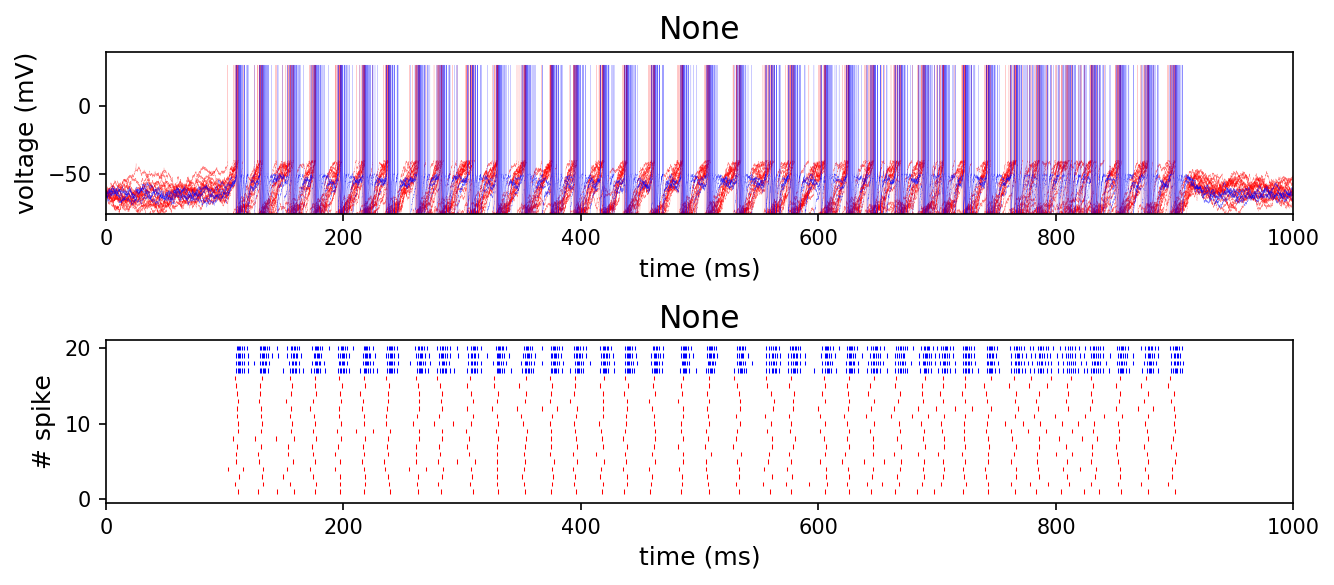

In [402]:
cs = ['r', 'b']
plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(2,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
basic_labeling()
plt.ylim([-80, 40])

plt.subplot(2,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling()
plt.ylabel('# spike')
# plt.yticks(np.arange(0, 11, 2))
plt.ylim([-0.5, n_cells+1])
# plt.xlim([1200, 1300])
std_i = np.std(ntk.vcells, axis=0)
std_all = np.std(np.average(ntk.vcells, 1))
si = std_all * ntk.nn / sum(std_i)
print(si)

plt.tight_layout()
plt.show()

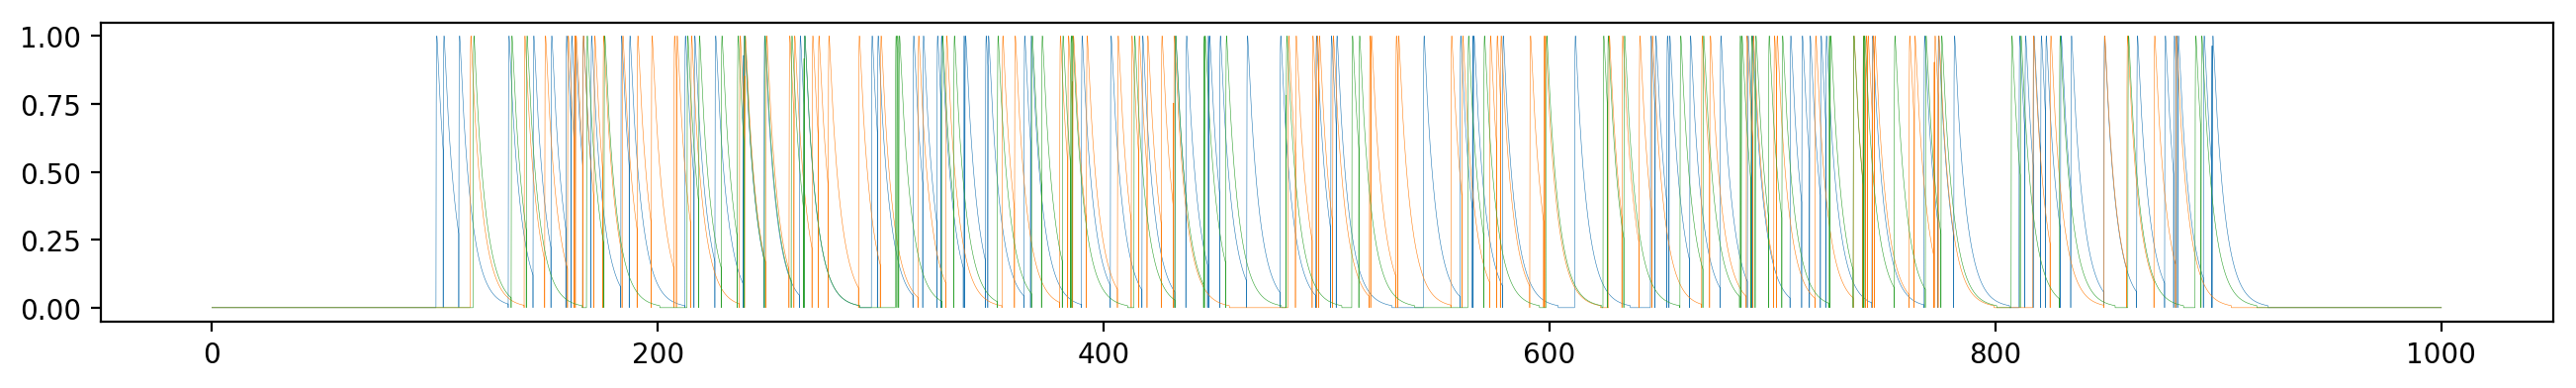

In [403]:
plt.figure(dpi=200, figsize=(16, 2))
plt.plot(nrn._times[1:], g_excs[:, :3], lw=0.2)
plt.show()

In [404]:
vsum = np.average(ntk.vcells, axis=1)

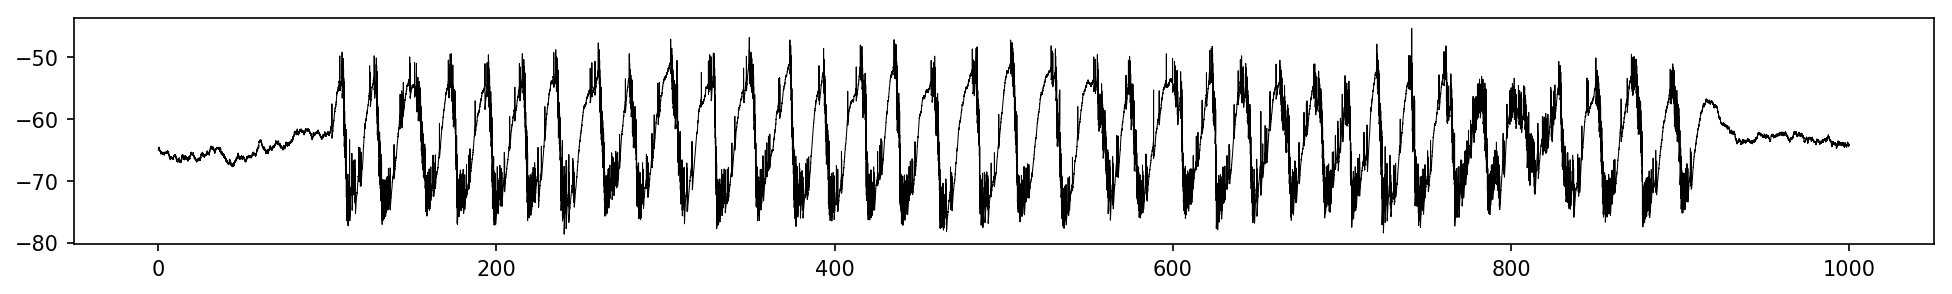

In [405]:
plt.figure(dpi=150, figsize=(16, 2))
plt.plot(nrn._times, vsum, 'k', lw=0.5)
# plt.xlim([1200, 1300])
plt.show()

In [406]:
idt = (nrn._times>500) & (nrn._times<3500)
f, fx = getFFT(vsum, idt)
idf = f > 1
f = f[idf]
fx = fx[idf]
n = 10
fx_avg = moving_average(fx, n=n)

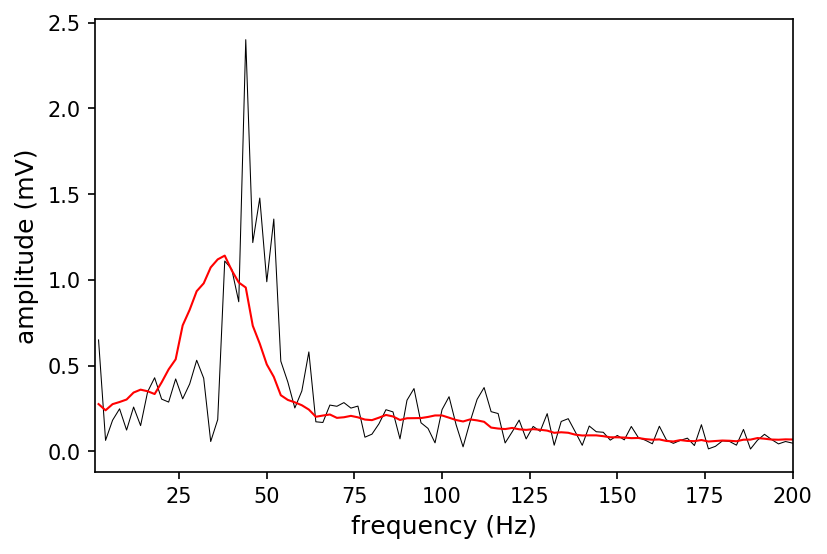

In [407]:
plt.figure(dpi=150)
plt.plot(f, fx, 'k', lw=0.5)
plt.plot(f[:-n+1], fx_avg, 'r', lw=1)
plt.xlim([1, 200])
# plt.ylim([0, 0.3])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel('amplitude (mV)', fontsize=12)
plt.show()

## random network

In [424]:
nrn.set_times(tmax=1000, dt=0.01)
seed = 102107
nrn.set_seed(seed)

In [425]:
def create_random_ntk(n_exc, n_inh, probs):
    n_cells = n_exc + n_inh
    cell_types = []
    cnt_map = np.ones([n_cells, n_cells], dtype=np.int) * (-1)
    gtype = [[0, 1], [2, 3]]
    for i in range(n_cells):
        if i < n_exc:
            cell_types.append(0)
        else:
            cell_types.append(1)
            
    for i in range(n_cells):
        cpre = cell_types[i]
        for j in range(n_cells):
            if i != j:
                cpost = cell_types[j]
                p = np.random.uniform(0, 1)
                if p <= probs[cpre][cpost]:
                    cnt_map[i][j] = gtype[cpre][cpost]
    return cell_types, cnt_map

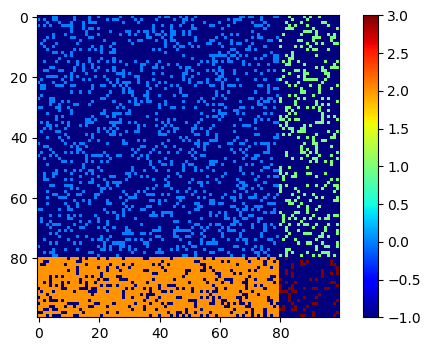

In [426]:
n_exc = 80
n_inh = 20
n_cells = n_exc + n_inh
probs = [[0.2, 0.2], [0.8, 0.2]]
# create cell types
cell_types, cnt_map = create_random_ntk(n_exc, n_inh, probs)

plt.figure(dpi=100)
plt.imshow(cnt_map, cmap='jet')
plt.colorbar()
plt.show()

In [481]:
# avg: 2
g_excs = []
e_excs = []
target_ids = []

targets = []
for i in range(n_cells):
    targets.append(i)
    targets.append(i)

for i in range(n_cells):
    g_excs.append(nrn.gPoisson(0.2, 0.1, 5, delay=0, t0=10, t1=nrn._tmax-10))
    e_excs.append(0)
    # pick two cells
    target_ids.append([np.random.choice(targets)])
    targets.remove(target_ids[-1][0])
    while True:
        n = np.random.choice(targets)
        if n != target_ids[-1][0]:
            target_ids[-1].append(n)
            targets.remove(target_ids[-1][1])
            break
g_excs = np.array(g_excs).T

In [505]:
# syn_pn2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pn2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pv2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

syn_pn2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pn2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':-80}
syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

# syn_pn2pn = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pn2pv = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':2, 'es':0}
# syn_pv2pn = {'gbar_syn':0.01, 'tau_r':0.1, 'tau_d':2, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [506]:
gbar_excs = []
for i in range(n_cells):
    gbar_excs.append([])
    for j in target_ids[i]:
        if cell_types[j] == 0: # exc
            gbar_excs[-1].append(syn_pn2pn['gbar_syn'])
        else: # inh
#             gbar_excs[-1].append(syn_pn2pv['gbar_syn'])
#             gbar_excs[-1].append(0.001)
            gbar_excs[-1].append(0.0001)

In [507]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, cnt_map)

In [508]:
ntk = nrn.CellNetwork(**setting, g_ext=g_excs, e_ext=e_excs, gbar_ext=gbar_excs, target_id=target_ids, std=0.3)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [02:53<00:00, 576.37it/s]


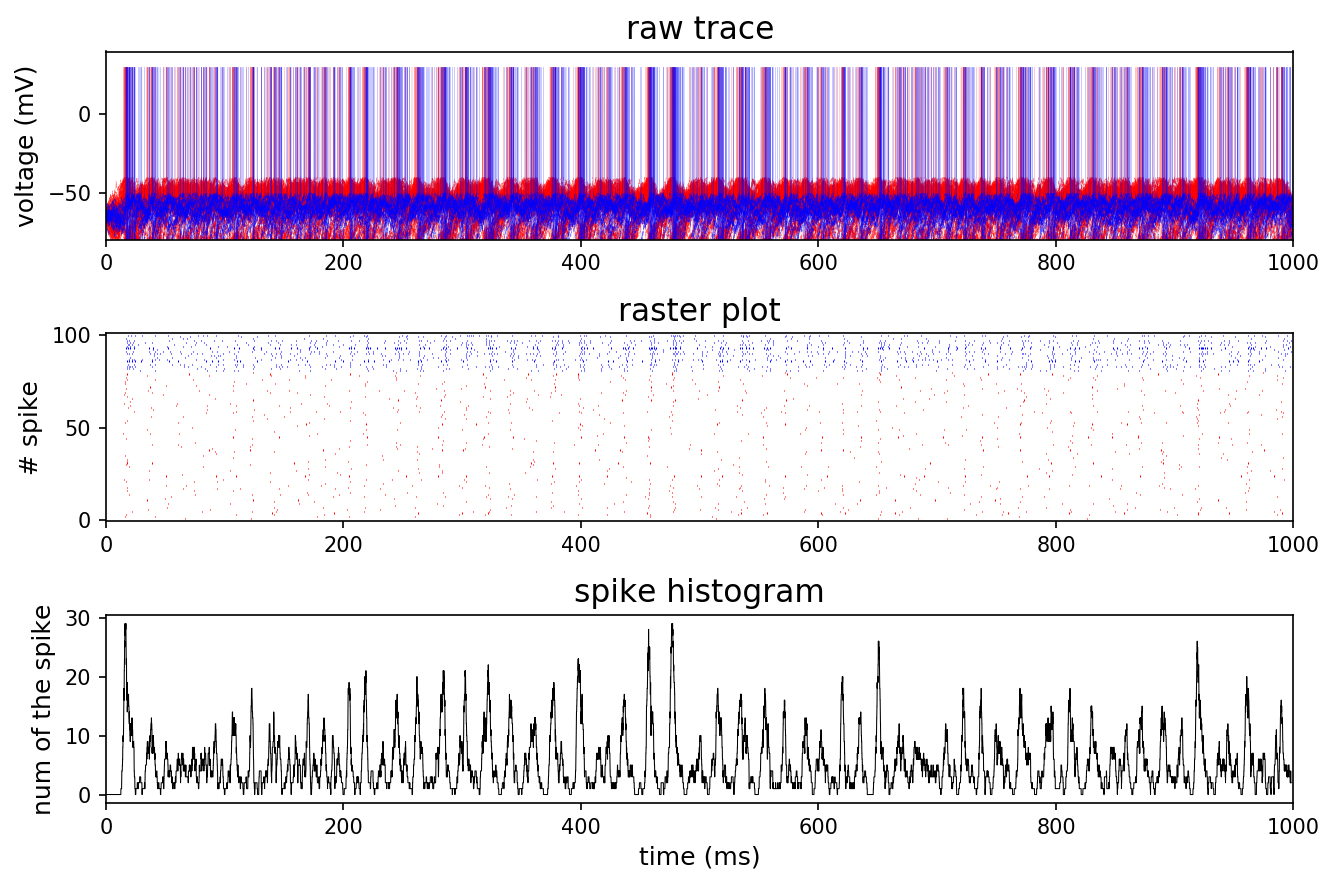

In [509]:
cs = ['r', 'b']
plt.figure(dpi=150, figsize=(9, 6))
plt.subplot(3,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
basic_labeling('raw trace')
plt.ylim([-80, 40])
plt.xlabel('')

plt.subplot(3,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling('raster plot')
plt.ylabel('# spike')
# plt.yticks(np.arange(0, 11, 2))
plt.ylim([-0.5, n_cells+1])
plt.xlabel('')

hist, x = get_spk_hist(ntk.vcells, nrn._times, w=200, m=5)
plt.subplot(3,1,3)
plt.plot(x, hist, 'k', lw=0.5)
basic_labeling('spike histogram')
plt.ylabel('num of the spike')

plt.tight_layout()
plt.show()

In [510]:
std_i = np.std(ntk.vcells, axis=0)
std_all = np.std(np.average(ntk.vcells, 1))
si = std_all * ntk.nn / sum(std_i)
print(si)

0.21161762902362913


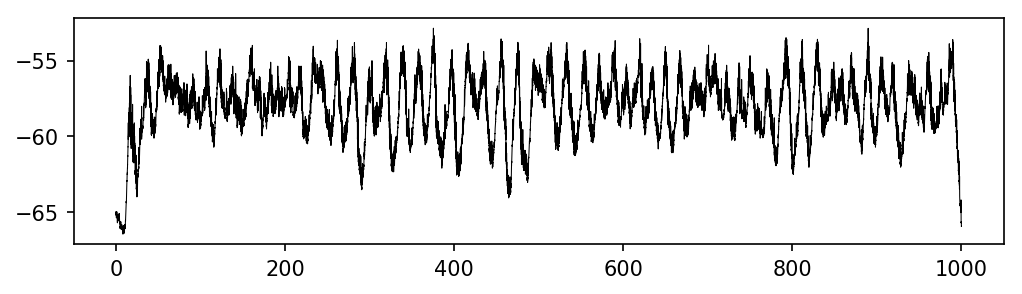

In [511]:
plt.figure(dpi=150, figsize=(8, 2))
plt.plot(nrn._times, np.average(ntk.vcells, axis=1), 'k', lw=0.5)
plt.show()

In [512]:
vsum = np.average(ntk.vcells, axis=1)

In [513]:
idt = (nrn._times>10) & (nrn._times<nrn._tmax-10)
f, fx = getFFT(vsum, idt)
idf = f > 1
f = f[idf]
fx = fx[idf]

In [514]:
n = 10
fx_avg = moving_average(fx, n=n)

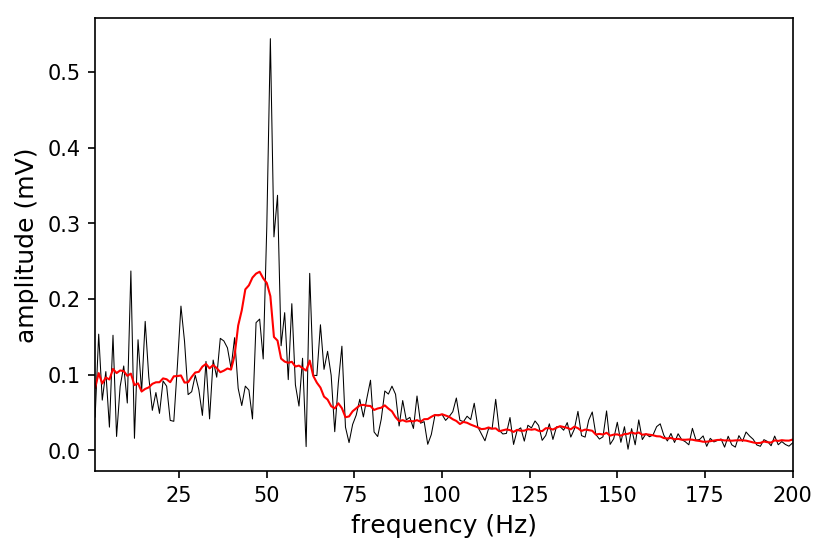

In [515]:
plt.figure(dpi=150)
plt.plot(f, fx, 'k', lw=0.5)
plt.plot(f[:-n+1], fx_avg, 'r', lw=1)
plt.xlim([1, 200])
# plt.ylim([0, 0.3])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel('amplitude (mV)', fontsize=12)
plt.show()